In [3]:
%pylab notebook

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.5/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['sqrt']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [4]:
from matplotlib import pyplot

In [26]:
from collections import namedtuple
Ellipse = namedtuple("Ellipse", ["center_1", "center_2", "angle", "half_long_axis", "half_short_axis"])
from math import atan2, sqrt

def fit_ellipse(pty, ptx, _allow_delta=True):
    """Fit an ellipse

    inspired from
    http://nicky.vanforeest.com/misc/fitEllipse/fitEllipse.html

    :param pty: point coordinates in the slow dimension (y)
    :param ptx: point coordinates in the fast dimension (x)
    :raise ValueError: If the ellipse can't be fitted
    """
    x = ptx[:, numpy.newaxis]
    y = pty[:, numpy.newaxis]
    D = numpy.hstack((x * x, x * y, y * y, x, y, numpy.ones_like(x)))
    S = numpy.dot(D.T, D)
    try:
        inv = numpy.linalg.inv(S)
    except numpy.linalg.LinAlgError:
        if not _allow_delta:
            raise ValueError("Ellipse can't be fitted")
        # Try to do the same with a delta
        delta = 100
        ellipse = fit_ellipse(pty + delta, ptx + delta, _allow_delta=False)
        y0, x0, angle, wlong, wshort = ellipse
        return Ellipse(y0 - delta, x0 - delta, angle, wlong, wshort)
    C = numpy.zeros([6, 6])
    C[0, 2] = C[2, 0] = 2
    C[1, 1] = -1
    E, V = numpy.linalg.eig(numpy.dot(inv, C))
    n = numpy.argmax(numpy.abs(E))
    res = V[:, n]
    b, c, d, f, g, a = res[1] / 2, res[2], res[3] / 2, res[4] / 2, res[5], res[0]
    num = b * b - a * c
    x0 = (c * d - b * f) / num
    y0 = (a * f - b * d) / num
    if b == 0:
        if a > c:
            angle = 0
        else:
            angle = pi / 2
    else:
        if a > c:
            angle = atan2(2 * b, (a - c)) / 2
        else:
            angle = numpy.pi / 2 + atan2(2 * b, (a - c)) / 2
    up = 2 * (a * f * f + c * d * d + g * b * b - 2 * b * d * f - a * c * g)
    down1 = (b * b - a * c) * ((c - a) * sqrt(1 + 4 * b * b / ((a - c) * (a - c))) - (c + a))
    down2 = (b * b - a * c) * ((a - c) * sqrt(1 + 4 * b * b / ((a - c) * (a - c))) - (c + a))

    a2 = up / down1
    b2 = up / down2
    if a2 < 0 or b2 < 0:
        raise ValueError("Ellipse can't be fitted")

    res1 = numpy.sqrt(a2)
    res2 = numpy.sqrt(b2)
    return Ellipse(y0, x0, angle, max(res1, res2), min(res1, res2))

In [27]:
from matplotlib import patches

def display(ptx, pty, ellipse=None):
    fig = pyplot.figure()
    ax = fig.add_subplot(111)
    if ellipse is not None:
        error = False
        y0, x0, angle, wlong, wshort = ellipse
        if wshort == 0:
            error = True
            wshort = 0.0001
        if wlong == 0:
            error = True
            wlong = 0.0001
        patch = patches.Arc((x0, y0), width=wlong*2, height=wshort*2,
                            angle=angle*180/numpy.pi)
        if error:
            patch.set_color("red")
        else:
            patch.set_color("green")
        ax.add_patch(patch)

        bbox = patch.get_window_extent()
        ylim = min(y0 - wlong, pty.min()), max(y0 + wlong, pty.max())
        xlim = min(x0 - wlong, ptx.min()), max(x0 - wlong, ptx.max())
    else:
        ylim = pty.min(), pty.max()
        xlim = ptx.min(), ptx.max()
    ax.plot(ptx, pty, "ro", color="blue")
    ax.set_xlim(*xlim)
    ax.set_ylim(*ylim)
    pyplot.show()

<IPython.core.display.Javascript object>


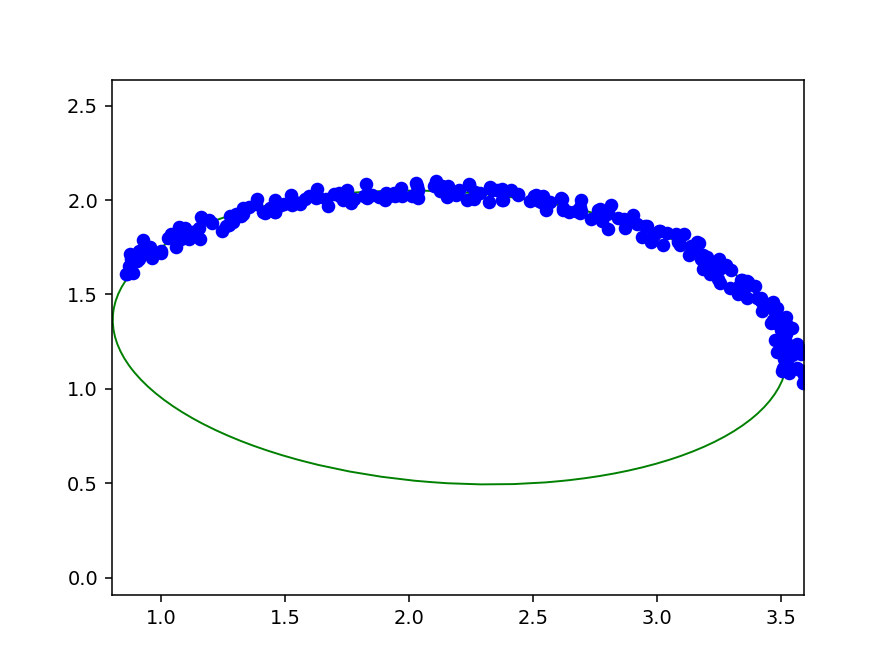

In [42]:
arc = 0.8
R = np.arange(0,arc*np.pi, 0.01)
ptx = 1.5*np.cos(R) + 2 + 0.1*np.random.rand(len(R))
pty = np.sin(R) + 1. + 0.1*np.random.rand(len(R))

ellipse = fit_ellipse(pty, ptx)
display(ptx, pty, ellipse)

Ellipse(center_1=10.000000000332909, center_2=10.000000000325038, angle=2.3689992424085746, half_long_axis=19.999999999804693, half_short_axis=19.999999999532037)


<IPython.core.display.Javascript object>


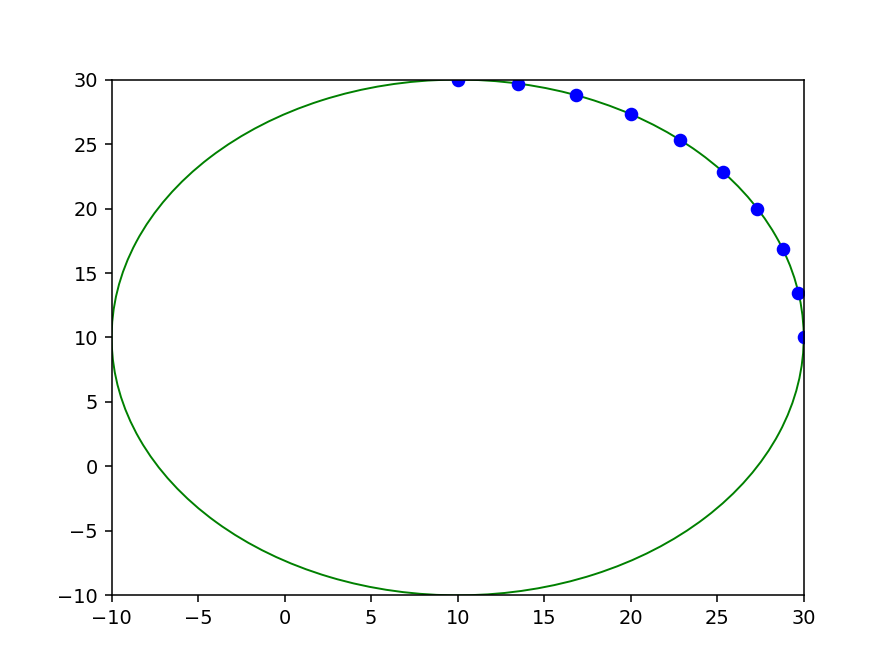

In [41]:
angles = numpy.linspace(0, numpy.pi / 2, 10)
pty = numpy.sin(angles) * 20 + 10
ptx = numpy.cos(angles) * 20 + 10
ellipse = fit_ellipse(pty, ptx)
print(ellipse)
display(ptx, pty, ellipse)

Ellipse(center_1=50.00000000000319, center_2=99.99999999999967, angle=3.141592653585416, half_long_axis=20.00000000004755, half_short_axis=9.999999999975287)


<IPython.core.display.Javascript object>


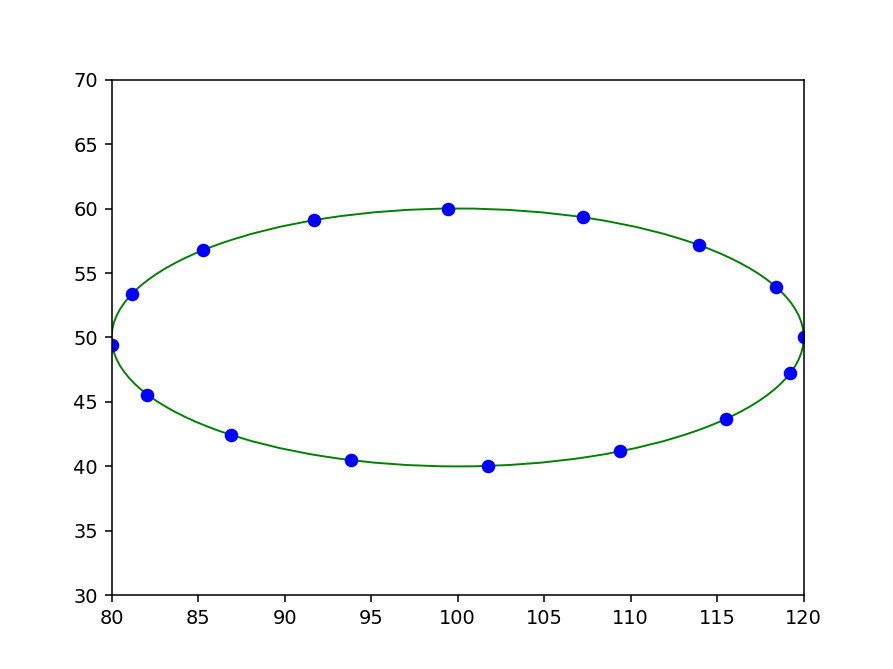

In [40]:
angles = numpy.arange(0, numpy.pi * 2, 0.4)
pty = numpy.sin(angles) * 10 + 50
ptx = numpy.cos(angles) * 20 + 100
ellipse = fit_ellipse(pty, ptx)
print(ellipse)
display(ptx, pty, ellipse)

Ellipse(center_1=5.201172825763933e-12, center_2=-2.4016344468691386e-12, angle=3.141592653581681, half_long_axis=20.000000000142578, half_short_axis=9.999999999924645)


<IPython.core.display.Javascript object>


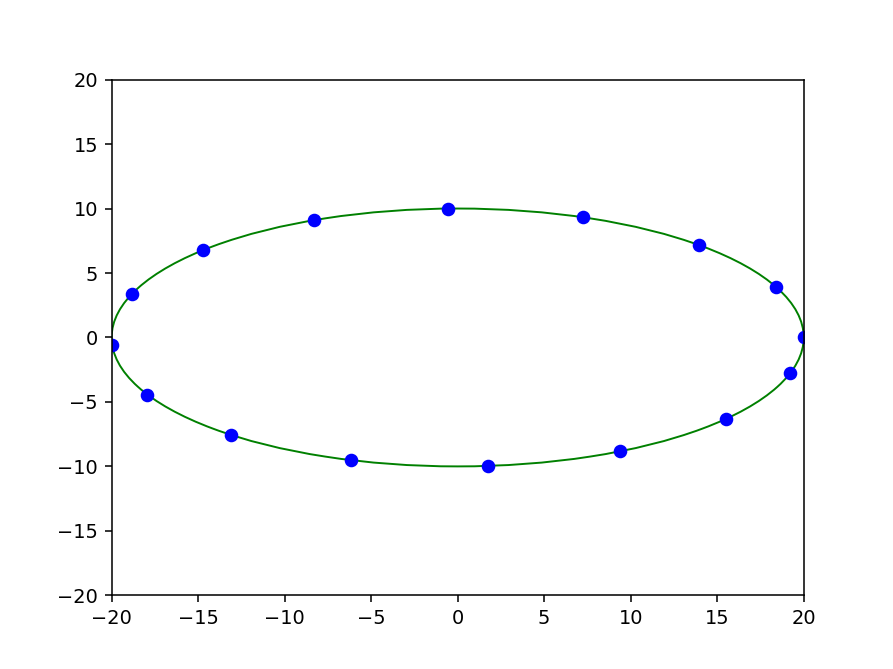

In [39]:
# Center to zero
angles = numpy.arange(0, numpy.pi * 2, 0.4)
pty = numpy.sin(angles) * 10 + 0
ptx = numpy.cos(angles) * 20 + 0
ellipse = fit_ellipse(pty, ptx)
print(ellipse)
display(ptx, pty, ellipse)

Ellipse(center_1=49.999999999999865, center_2=99.99999999999977, angle=0.5535743588962649, half_long_axis=18.09016994368954, half_short_axis=6.909830056273027)


<IPython.core.display.Javascript object>


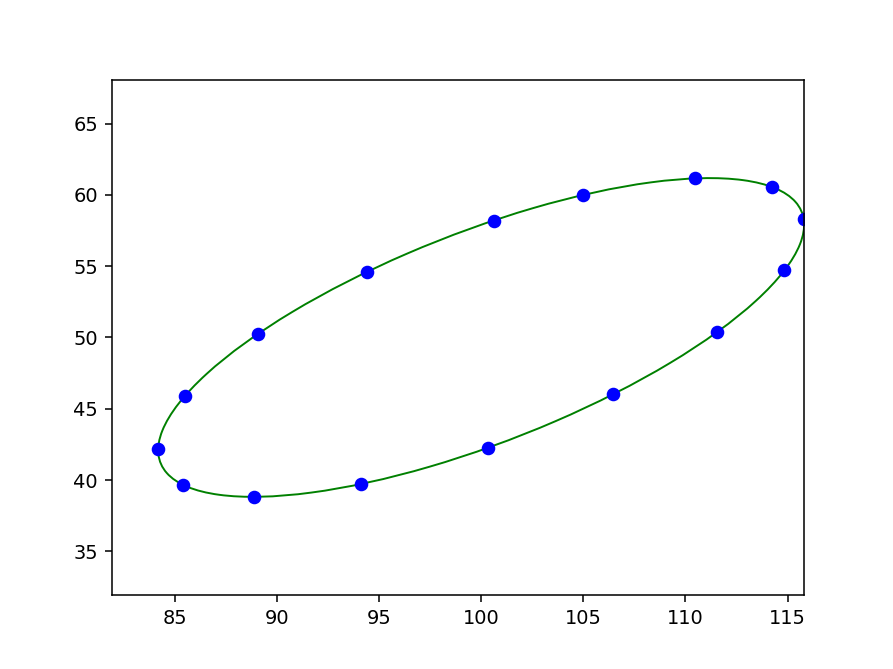

In [38]:
angles = numpy.arange(0, numpy.pi * 2, 0.4)
pty = 50 + 10 * numpy.cos(angles) + 5 * numpy.sin(angles)
ptx = 100 + 5 * numpy.cos(angles) + 15 * numpy.sin(angles)
ellipse = fit_ellipse(pty, ptx)
print(ellipse)
display(ptx, pty, ellipse)
# Wrong result, maybe a problem with the matplotlib patch

Ellipse can't be fitted


<IPython.core.display.Javascript object>


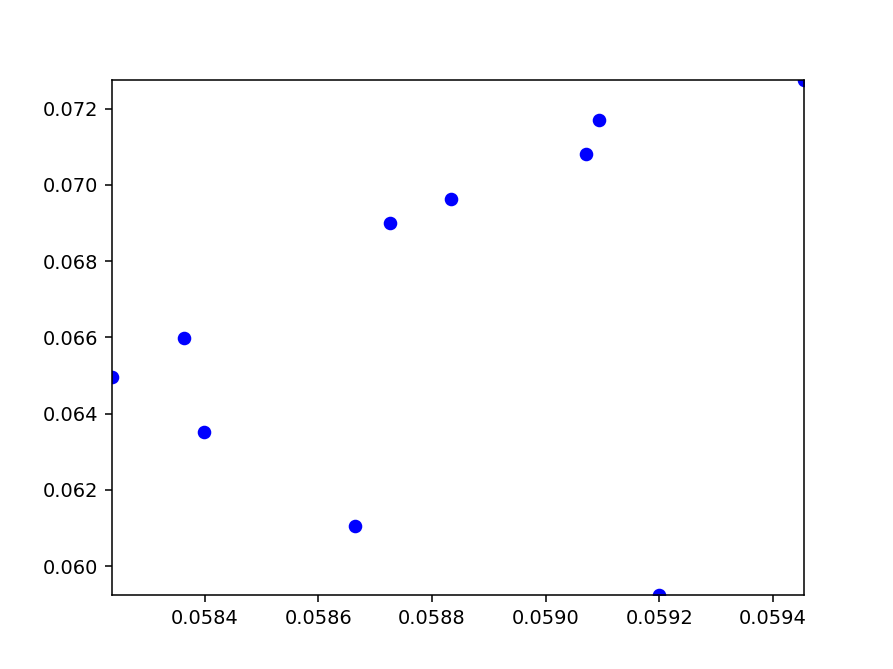

In [37]:
# Points from real peaking
pty = numpy.array([0.06599215, 0.06105629, 0.06963708, 0.06900191, 0.06496001, 0.06352082, 0.05923421, 0.07080027, 0.07276284, 0.07170048])
ptx = numpy.array([0.05836343, 0.05866434, 0.05883284, 0.05872581, 0.05823667, 0.05839846, 0.0591999, 0.05907079, 0.05945377, 0.05909428])
try:
    ellipse = fit_ellipse(pty, ptx)
except Exception as e:
    ellipse = None
    print(e)
display(ptx, pty, ellipse)

Ellipse can't be fitted


<IPython.core.display.Javascript object>


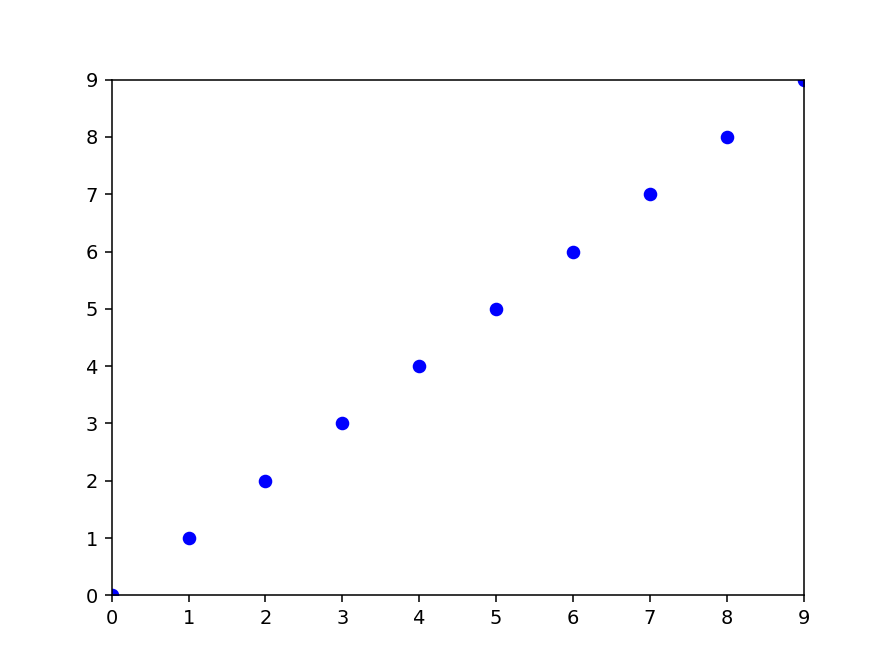

In [35]:
# Line
pty = numpy.arange(10)
ptx = numpy.arange(10)
try:
    ellipse = fit_ellipse(pty, ptx)
except Exception as e:
    ellipse = None
    print(e)
display(ptx, pty, ellipse)